In [61]:
# This code finds higher modes of a dilute axion star via a shooting method
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

In [73]:
# Interval of solution and number of steps
ri, rf, dr = 0, 60, 0.005
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# Right-hand side of ODEs from Eq. (20) on my "Notes on Axion Stars", here X = [\tilde{\Psi}, \chi, \tilde{\phi}, \xi]
def f(r, X):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0]
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# Step of RK4
def rk4step(r, X):
    k1 = dr*f(r, X)
    k2 = dr*f(r + dr/2, X + k1/2)
    k3 = dr*f(r + dr/2, X + k2/2)
    k4 = dr*f(r + dr, X + k3)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

# Full RK4
def rk4(Xbc, nodes_target):
    # initialize the arrays
    Xs = np.zeros((4, steps))

    # Boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # Perform RK4
    bpoint, nodes, peaks = 0, -1, -1
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1])

        if np.isnan(Xs[..., step][0]):
            break 

        # Find number of nodes and peaks (points with zero derivative)
        nodes, peaks = nnodes(Xs[0][:step]), npeaks(Xs[0][:step])
    
        # The breakpoint 'bpoint' occurs when the solution with the right number of nodes stops converging to zero at r -> infty
        sign_nodes = np.power(-1, nodes_target)
        if (sign_nodes*Xs[..., step][0] > sign_nodes*Xs[..., step - 1][0] or sign_nodes*Xs[..., step][0] < 0) and nodes == nodes_target and peaks == nodes:
            bpoint = step
            return Xs, bpoint, nodes

    return Xs, bpoint, nodes

# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold, nodes_target):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint, nodes = rk4(Xbc_step, nodes_target)

    # If the breakpoint happens for higher values of r, keep the new solution
    if bpoint > bpointold and nodes == nodes_target:
        return True, bpoint, nodes
    else:
        return False, bpointold

# Full Monte Carlo
def find_sol(nodes_target):
    bpoint = 0
    phi0 = np.random.uniform(-2,0)

    nsteps = 5000
    count, step_stdev = 0, 1
    for i in np.arange(nsteps):
        # Give a random kick to phi0
        phi0old = phi0
        phi0 += np.random.normal(0,step_stdev)

        mcs = mc_step(phi0, bpoint, nodes_target)
        if mcs[0]:  # If a larger 'bpoint' is found, keep
            bpoint = mcs[1]
        else:   # If not, back to old valur of phi0
            phi0 = phi0old
            count += 1
        
        # Variable 'count' avoids the code 'getting stuck' for large periods of time, makes step smaller when it happens
        if count > 100:
            count = 0
            step_stdev = step_stdev/10

        # If the solution does not break in the interval or step is too small, stop
        if bpoint == steps - 1 or step_stdev < 1e-20:
            return phi0, bpoint

    return phi0, bpoint

# Asymptotic behavior of phi
def fit_asymp(r, C, epsilonb):
        return C/r + epsilonb

def find_epsilonb(rinterv_loc, Xs):
    # Find epsilonb from asymptotic behavior of phi
    tail_ini = 100
    r_asymp, phi_asymp = rinterv_loc[-tail_ini:-1], Xs[2].T[-tail_ini:-1]
    popt, pcov = curve_fit(fit_asymp, r_asymp, phi_asymp)
    # The error from the fit is epsilonb_stdev
    epsilonb, epsilonb_stdev = popt[1], np.sqrt(np.diag(pcov))[1] 
    return epsilonb, epsilonb_stdev

# Number of nodes of a 1d function described by an array Xs
def nnodes(Xs):
    Xs_prod = Xs[:len(Xs) - 1]*Xs[1:len(Xs)]
    return (Xs_prod < 0).sum()

# Number of peaks (points with zero derivative) of a 1d function described by an array Xs
def npeaks(Xs):
    Xs_diffs = Xs[1:len(Xs)] - Xs[:len(Xs) - 1]
    Xs_diffs_prod = Xs_diffs[:len(Xs_diffs) - 1]*Xs_diffs[1:len(Xs_diffs)]
    return (Xs_diffs_prod < 0).sum()

In [74]:
# Find solutions with number of nodes from nodes_min to nodes_max
nodes_min, nodes_max = 1, 8
nodes_lst = np.arange(nodes_min, nodes_max + 1)

start_time = time.time()
all_phi0s = []
for node in nodes_lst:
    thisphi0 = find_sol(node)[0]
    all_phi0s.append(thisphi0)

    print('Found solution for ', node, ' nodes. It took ', (time.time() - start_time)/60, ' minutes.')
    start_time = time.time()


# Save phi0s for all the different number of nodes
a_file = open("output/allphis.txt", "w")

np.savetxt(a_file, all_phi0s)

a_file.close()

C:\Users\gsali\AppData\Local\Temp/ipykernel_13176/3365660765.py:9: RuntimeWarning: overflow encountered in double_scalars
  f2 = -2*X[1]/r + 2*X[2]*X[0]
C:\Users\gsali\AppData\Local\Temp/ipykernel_13176/3365660765.py:11: RuntimeWarning: overflow encountered in power
  f4 = -2*X[3]/r + np.power(X[0],2)
C:\Users\gsali\AppData\Local\Temp/ipykernel_13176/3365660765.py:9: RuntimeWarning: invalid value encountered in double_scalars
  f2 = -2*X[1]/r + 2*X[2]*X[0]
C:\Users\gsali\AppData\Local\Temp/ipykernel_13176/3365660765.py:11: RuntimeWarning: invalid value encountered in double_scalars
  f4 = -2*X[3]/r + np.power(X[0],2)


Found solution for  1  nodes. It took  475.6866466999054  seconds.
Found solution for  2  nodes. It took  1088.5178201198578  seconds.
Found solution for  3  nodes. It took  1821.6884479522705  seconds.
Found solution for  4  nodes. It took  2741.47789311409  seconds.
Found solution for  5  nodes. It took  3800.6445832252502  seconds.
Found solution for  6  nodes. It took  5110.411677360535  seconds.
Found solution for  7  nodes. It took  6532.077146291733  seconds.
Found solution for  8  nodes. It took  7387.486933231354  seconds.


The value of epsilonb is:  0.5984572311344485
The value of tilde phi0 is:  -1.157472042188273


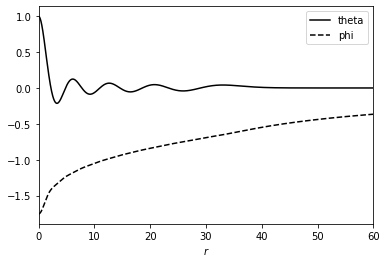

In [92]:
all_phi0s = np.loadtxt('output/allphis.txt')

# Plotting solution with number of nodes equal to nodes_target
nodes_target = 8
phi0_plt = all_phi0s[nodes_target - 1]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint, nodes = rk4(Xbc_plt, nodes_target)
rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
print('The value of epsilonb is: ', epsilonb)
print('The value of tilde phi0 is: ', Xs[2].T[0])


plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
plt.xlabel(r"$r$")
plt.xlim(left = 0, right = rinterv[bpoint])
plt.legend();

# name_file = 'plots/' + str(nodes_target) + 'nodes.pdf'
# plt.savefig(name_file, dpi = 300, bbox_inches='tight')


In [110]:
# Save all plots
for i, phi0 in enumerate(all_phi0s):
    nodes_here = i + 1
    Xbc_plt = np.array([1, 0, phi0, 0])
    Xs, bpoint, nodes = rk4(Xbc_plt, nodes_here)
    rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]
    epsilonb = find_epsilonb(rinterv_cut, Xs)[0]

    plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
    plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
    plt.xlabel(r"$r$")
    plt.xlim(left = 0, right = rinterv[bpoint])
    textstr = 'n = ' + str(nodes_here)
    plt.text(0.90, 0.925, textstr, fontsize=14, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    name_file = 'plots/' + str(nodes_here) + 'nodes.pdf'
    plt.savefig(name_file, dpi = 300, bbox_inches='tight')
    plt.close()